In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import pickle
import sys
import time
import numpy as np
#from nltk.corpus import stopwords
#from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import string
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import lda
import pyLDAvis
import pyLDAvis.gensim_models
import spacy
from spacy.lang.de.stop_words import STOP_WORDS
#from spacy.tokens import Doc
#from HanTa import HanoverTagger as ht
%matplotlib inline

### Creating the corpus

In [3]:
#with open('files/souplist.txt', 'r', encoding='utf-8') as f:
    #souplist = f.read()

In [4]:
#souplist = souplist.split('BREAKHERE')

In [5]:
#articles = []
#for s in souplist:
    #soup = BeautifulSoup(s, 'lxml')
    #for text in soup.find_all('div', attrs={'class': 'avia_textblock'}):
        #paragraphs = []
        #paragraphs.append(text.text)
        #print(text.text)
        #print('___')
        #for paragraph in paragraphs:
            #articles.append(paragraph)

In [6]:
#corpus = ' '.join(articles)
#with open('files/corpus.txt', 'w', encoding='utf-8') as file:
    #file.write(corpus)

In [2]:
with open('files/corpus.txt', 'r', encoding='utf-8') as f:
    corpus = f.read()

In [3]:
corpus[0:10000]

'\n\n\n              Ist die Hausdurchsuchung bei Identitären-Chef Sellner verraten worden? Und: Wer hat sie verraten? Geheimdokumente belasten Kickls Mann fürs Harte: Peter Goldgruber, seinen Generalsekretär im Innenministerium. Peter Pilz, Spitzenkandidat von JETZT stellt eine parlamentarische Anfrage an das Innenministerium, um den Fall aufzuklären.\n              \n\n\n\n             Wien, 04.08.2019 / Schon kurz nach dem Terror-Anschlag im neuseeländischen Christchurch ist klar: Eine entscheidende Spur führt zu Martin Sellner, dem Chef der rechtsextremen Identitären Bewegung Österreichs, der IBÖ. Fünf Tage nach dem Anschlag erteilt Generalsekretär Goldgruber am 20. März 2019 BVT-Direktor Peter Gridling eine Weisung:\n             \n              „Über getroffene Maßnahmen und festgestellte Lage ist (…) bis auf weiteres jeden Freitag bis 12 Uhr zu berichten.“\n             \n\n\n             Einen Tag später um 13.54 Uhr verstärkt Goldgruber den Druck auf den BVT-Direktor: „\n     

### Cleaning the corpus

In [4]:
def clean_corpus(corpus):
    corpus = re.sub(r'\s{2,}', ' ', corpus)
    corpus = corpus.lower()
    corpus = re.sub('[%s]' % re.escape(string.punctuation), '', corpus)
    corpus = re.sub(r'\w*\d\w*', '', corpus)
    corpus = re.sub('[„“‚‘…”–’]', '', corpus)
    return corpus

In [5]:
corpus = clean_corpus(corpus)
corpus[0:10000]

' ist die hausdurchsuchung bei identitärenchef sellner verraten worden und wer hat sie verraten geheimdokumente belasten kickls mann fürs harte peter goldgruber seinen generalsekretär im innenministerium peter pilz spitzenkandidat von jetzt stellt eine parlamentarische anfrage an das innenministerium um den fall aufzuklären wien   schon kurz nach dem terroranschlag im neuseeländischen christchurch ist klar eine entscheidende spur führt zu martin sellner dem chef der rechtsextremen identitären bewegung österreichs der ibö fünf tage nach dem anschlag erteilt generalsekretär goldgruber am  märz  bvtdirektor peter gridling eine weisung über getroffene maßnahmen und festgestellte lage ist  bis auf weiteres jeden freitag bis  uhr zu berichten einen tag später um  uhr verstärkt goldgruber den druck auf den bvtdirektor  lieber peter ich ersuche um ergänzende information ob sellner oder andere mitglieder ibö bereits befragt wurden goldgruber ließ sich informieren goldgruber und sellner wissen z

In [6]:
newStopWords = ['wien','titelbild', 'picturedesk', 'apa', 'zackzack', 'e', 'de', 'al', 'au', 'bi', 'wa', 'mus', 'un', 'dy', 'könnte', 'sieht', 'ap']
for i in newStopWords:
    STOP_WORDS.add(i)

In [7]:
words_to_remove = ['kurz']
for i in words_to_remove:
    STOP_WORDS.remove(i)

In [8]:
#print(stop_words)
print(STOP_WORDS)
print(len(STOP_WORDS))

{'deiner', 'mag', 'das', 'ins', 'zur', 'viertes', 'sei', 'derselben', 'durften', 'wollten', 'meines', 'den', 'leicht', 'zehnten', 'darunter', 'wem', 'jenes', 'dritte', 'darauf', 'müssen', 'außerdem', 'werdet', 'bi', 'nahm', 'einige', 'wohl', 'achten', 'besten', 'tage', 'der', 'müsst', 'kommt', 'darf', 'ag', 'sich', 'weil', 'sehr', 'allerdings', 'gleich', 'habe', 'daraus', 'beispiel', 'vom', 'lang', 'eben', 'einmaleins', 'jeden', 'mus', 'vor', 'lieber', 'ihm', 'morgen', 'oft', 'einander', 'desselben', 'wenn', 'dagegen', 'mochte', 'nach', 'allem', 'sechstes', 'nie', 'gute', 'siebten', 'jahren', 'demgemäß', 'dieselbe', 'vergangenen', 'dementsprechend', 'dieselben', 'oben', 'so', 'mehr', 'hinter', 'tun', 'grosse', 'gibt', 'ganzen', 'daneben', 'er', 'wirklich', 'gut', 'ende', 'ap', 'infolgedessen', 'grosser', 'macht', 'wollt', 'auf', 'schon', 'kleines', 'dürfen', 'am', 'geht', 'wegen', 'habt', 'da', 'mich', 'deinem', 'keiner', 'drei', 'willst', 'demzufolge', 'ohne', 'jahr', 'anderen', 'erst

In [9]:
word_tokens = word_tokenize(corpus)

In [10]:
filtered_corpus = [w for w in word_tokens if w not in STOP_WORDS]

In [11]:
#The lemmatizer did not work well in conjunction with the selected stopwords list. In fact, the data is cleaner without the lemmatizer.

#tagger = ht.HanoverTagger('morphmodel_ger.pgz')

#lemma_tokens = []
#for token in filtered_word_tokens:
#    lemma = [lemma for (word,lemma,pos) in tagger.tag_sent(token.split())]
#    lemma_tokens.append(' '.join(lemma))
#filtered_corpus = [token.lower() for token in lemma_tokens]
#filtered_corpus = [w for w in word_tokens if w not in lemma_tokens]

### Exploratory Data Analysis

In [12]:
freqdist = Counter(filtered_corpus)
freqdist.most_common(50)

[('kurz', 6574),
 ('övp', 5307),
 ('österreich', 4540),
 ('prozent', 3856),
 ('menschen', 3699),
 ('euro', 3523),
 ('regierung', 3135),
 ('laut', 3100),
 ('millionen', 2510),
 ('spö', 2343),
 ('grünen', 2146),
 ('sebastian', 2093),
 ('fpö', 1921),
 ('blümel', 1806),
 ('wiener', 1748),
 ('land', 1537),
 ('kanzler', 1527),
 ('märz', 1515),
 ('steht', 1441),
 ('strache', 1384),
 ('april', 1348),
 ('kritik', 1315),
 ('medien', 1312),
 ('personen', 1306),
 ('woche', 1295),
 ('jänner', 1278),
 ('frage', 1276),
 ('neos', 1271),
 ('polizei', 1269),
 ('mai', 1238),
 ('grüne', 1222),
 ('usa', 1209),
 ('trump', 1207),
 ('wochen', 1181),
 ('partei', 1178),
 ('maßnahmen', 1170),
 ('klar', 1160),
 ('coronavirus', 1154),
 ('letzten', 1152),
 ('november', 1141),
 ('lassen', 1125),
 ('montag', 1125),
 ('fast', 1123),
 ('derzeit', 1107),
 ('mal', 1106),
 ('sogar', 1101),
 ('peter', 1097),
 ('politik', 1090),
 ('dezember', 1080),
 ('gilt', 1072)]

In [13]:
cleaned = ' '.join(filtered_corpus)
wordcloud = WordCloud().generate(cleaned)

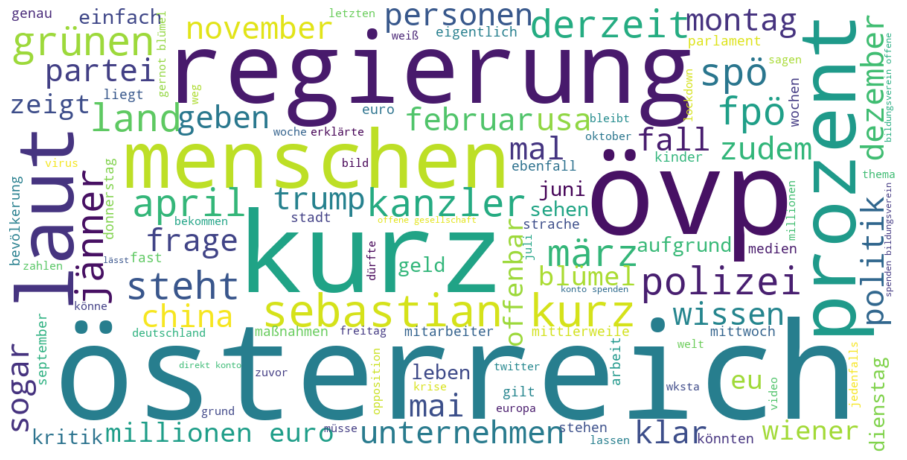

In [20]:
wordcloud = WordCloud(background_color='white', scale=3).generate(cleaned)
plt.figure(figsize=(16, 16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Creating the document term matrix

In [21]:
filtered_corpus =[filtered_corpus]

In [22]:
dictionary = corpora.Dictionary(filtered_corpus)
doc_term_matrix = [dictionary.doc2bow(i) for i in filtered_corpus]

### Running the model

In [23]:
Lda = gensim.models.ldamodel.LdaModel

In [24]:
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=100)

In [25]:
print(ldamodel.print_topics(num_topics=3, num_words=10))

[(0, '0.005*"kurz" + 0.004*"övp" + 0.004*"österreich" + 0.003*"prozent" + 0.003*"menschen" + 0.003*"euro" + 0.003*"regierung" + 0.002*"laut" + 0.002*"millionen" + 0.002*"spö"'), (1, '0.000*"kurz" + 0.000*"övp" + 0.000*"prozent" + 0.000*"österreich" + 0.000*"menschen" + 0.000*"euro" + 0.000*"laut" + 0.000*"millionen" + 0.000*"regierung" + 0.000*"grünen"'), (2, '0.000*"övp" + 0.000*"kurz" + 0.000*"österreich" + 0.000*"euro" + 0.000*"menschen" + 0.000*"prozent" + 0.000*"regierung" + 0.000*"millionen" + 0.000*"spö" + 0.000*"laut"')]


### Visualizing the topics-keywords

In [26]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.203763 -0.0       1        1  99.999943
2     -0.101882 -0.0       2        1   0.000028
1     -0.101882 -0.0       3        1   0.000028, topic_info=                  Term        Freq        Total Category  logprob  loglift
30200   entscheidungen  191.000000   191.000000  Default  30.0000  30.0000
12391         begonnen  192.000000   192.000000  Default  29.0000  29.0000
2511             aktiv  192.000000   192.000000  Default  28.0000  28.0000
125877     wirtschafts  191.000000   191.000000  Default  27.0000  27.0000
31248         erklären  191.000000   191.000000  Default  26.0000  26.0000
...                ...         ...          ...      ...      ...      ...
126376          wochen    0.000003  1159.731964   Topic3 -11.8012  -4.8426
63576           kritik    0.000003  1291.298396   Topic3 -11.8012  -4.9500
35131             fast    0.000003  1102.785492   Topic3 -11.8012  -4.7922
104197           steht    0.000003  1415.009819   Topic3 -11.8012  -5.0415
47262            grüne    0.000003  1199.987608   Topic3 -11.8012  -4.8767

[180 rows x 6 columns], token_table=        Topic      Freq         Term
term                                
2511        1  1.001963        aktiv
3474        1  0.877182  ambivalente
6028        1  1.000227        april
6959        1  1.001963      assange
11447       1  0.877182     bataclan
...       ...       ...          ...
127045      1  1.001793       wusste
128507      1  1.002047          zib
131334      1  1.000062   österreich
131452      1  1.000040          övp
132708      1  1.002047   übernehmen

[101 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### Evaluating different models

In [27]:
# Perplexity score
print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix,total_docs=1))

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamodel, texts=filtered_corpus, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.95064170770714

Coherence Score:  0.3192763616863571


In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=filtered_corpus, start=2, limit=50, step=1)

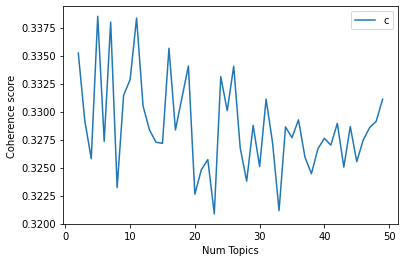

In [30]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [34]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3186
Num Topics = 3  has Coherence Value of 0.3262
Num Topics = 4  has Coherence Value of 0.3412
Num Topics = 5  has Coherence Value of 0.3311
Num Topics = 6  has Coherence Value of 0.3418
Num Topics = 7  has Coherence Value of 0.327
Num Topics = 8  has Coherence Value of 0.3235
Num Topics = 9  has Coherence Value of 0.3374
Num Topics = 10  has Coherence Value of 0.3314
Num Topics = 11  has Coherence Value of 0.3311
Num Topics = 12  has Coherence Value of 0.3452
Num Topics = 13  has Coherence Value of 0.3366
Num Topics = 14  has Coherence Value of 0.3295
Num Topics = 15  has Coherence Value of 0.3382
Num Topics = 16  has Coherence Value of 0.3342
Num Topics = 17  has Coherence Value of 0.3299
Num Topics = 18  has Coherence Value of 0.3354
Num Topics = 19  has Coherence Value of 0.3238
Num Topics = 20  has Coherence Value of 0.3345
Num Topics = 21  has Coherence Value of 0.3256
Num Topics = 22  has Coherence Value of 0.3256
Num Topics = 23  has C

In [31]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.005*"kurz" + 0.005*"övp" + 0.003*"österreich" + 0.003*"regierung" + 0.003*"menschen" + 0.003*"prozent" + 0.003*"euro" + 0.002*"laut" + 0.002*"spö" + 0.002*"millionen"'),
 (1,
  '0.004*"kurz" + 0.004*"övp" + 0.004*"österreich" + 0.003*"laut" + 0.003*"menschen" + 0.002*"euro" + 0.002*"regierung" + 0.002*"prozent" + 0.002*"sebastian" + 0.002*"spö"'),
 (2,
  '0.005*"kurz" + 0.003*"österreich" + 0.003*"menschen" + 0.003*"övp" + 0.002*"prozent" + 0.002*"euro" + 0.002*"laut" + 0.002*"spö" + 0.002*"grünen" + 0.002*"millionen"'),
 (3,
  '0.004*"kurz" + 0.004*"prozent" + 0.003*"övp" + 0.003*"österreich" + 0.003*"euro" + 0.003*"menschen" + 0.002*"millionen" + 0.002*"regierung" + 0.002*"sebastian" + 0.002*"laut"')]

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.003412  0.001419       1        1  59.410584
3     -0.000422 -0.001726       2        1  23.236946
2     -0.000414 -0.002212       3        1  12.205451
1     -0.002576  0.002519       4        1   5.147019, topic_info=              Term         Freq        Total Category  logprob  loglift
64312         kurz  6140.000000  6140.000000  Default  30.0000  30.0000
131334  österreich  3956.000000  3956.000000  Default  29.0000  29.0000
131452         övp  5390.000000  5390.000000  Default  28.0000  28.0000
66230         laut  2779.000000  2779.000000  Default  27.0000  27.0000
72350     menschen  3492.000000  3492.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
75942         märz    69.159181  1465.033516   Topic4  -6.8114  -0.0865
125141      wiener    68.245238  1584.160866   Topic4  -6.8247  -0.1780
71529       medien    58.877197  1229.714531   Topic4  -6.9723  -0.0723
6028         april    57.497216  1118.452039   Topic4  -6.9961  -0.0012
105130     strache    56.880148  1317.633071   Topic4  -7.0069  -0.1759

[384 rows x 6 columns], token_table=        Topic      Freq          Term
term                                 
903         1  0.499319      abrufbar
903         2  0.249660      abrufbar
903         3  0.187245      abrufbar
903         4  0.062415      abrufbar
948         1  0.486344  abscheuliche
...       ...       ...           ...
131405      4  0.069082   österreichs
131452      1  0.695668           övp
131452      2  0.183656           övp
131452      3  0.073277           övp
131452      4  0.047676           övp

[1052 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

In [43]:
#pyLDAvis.save_html(vis, 'topicmodel_vis.html')

### References

https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore